In [1]:
import matplotlib.pyplot as plt

# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance.

To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 


In [2]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

##trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
##trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

##testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
##testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [3]:
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
# len(trainset) => 60000

N_train = 55000
N_valid = 5000

trainset, validset = torch.utils.data.random_split(trainset, [N_train, N_valid])

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

In [4]:
bs = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=bs, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

In [8]:
print(len(trainset), len(validset), len(testset))
print(len(trainloader), len(validloader), len(testloader))

55000 5000 10000
860 79 157


## When you have data augmentation, use the following:
    
```python
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

train_dataset = datasets.FashionMNIST(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = datasets.FashionMNIST(root=DATASET_PATH, train=True, transform=test_transform, download=True)

set_seed(42) # a function that can be used to set a seed for random number generators
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])

set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

test_set = datasets.FashionMNIST(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# Data loaders
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
```

## Building the model

Copied from `Part 4 - Fashion-MNIST.ipynb`

In [9]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

## Compute the model's performance (i.e., accuracy in this example)

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [10]:
model = Classifier()

images, labels = next(iter(validloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the torch's `topk` method. 

`torch.topk(.)` or `tensor.topk(.)`: Returns the `k` largest elements of the given input tensor **along a given dimension**.

If the highest value is the fifth element, we'll get back 4 as the index.

In [11]:
a = torch.Tensor([1,2,3,4])

v,i = a.topk(k=1) # returns both values and indices

print(v)
print(i,"\n\n")

a = torch.Tensor([[1,2,3,4],[8,7,6,5]])
v,i = a.topk(k=2,dim=1)

print(v)
print(i)

tensor([4.])
tensor([3]) 


tensor([[4., 3.],
        [8., 7.]])
tensor([[3, 2],
        [0, 1]])


In [12]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples

print(ps[1,:])
print(top_class[1,:])
print(top_p[1,:])

tensor([0.0961, 0.0995, 0.0936, 0.0939, 0.1114, 0.1018, 0.0986, 0.0946, 0.1068,
        0.1036], grad_fn=<SliceBackward>)
tensor([4])
tensor([0.1114], grad_fn=<SliceBackward>)


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [13]:
equals = top_class == labels.view(*top_class.shape)

print(equals.shape)

torch.Size([64, 1])


Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implement for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [14]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 15.625%


## Train the network

In [49]:
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

Device: cuda


In [50]:
model = Classifier()
model.to(my_device)

criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 60 # 30

In [51]:
def train_loop(trainloader, model, criterion, optimizer):
    tot_train_loss = 0
    for images, labels in trainloader:
        
        images = images.to(my_device)
        labels = labels.to(my_device)
        
        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()

        loss.backward()
        optimizer.step()
    train_loss = tot_train_loss / len(trainloader.dataset)
    
    return train_loss

def test_loop(testloader, model, criterion):
    tot_test_loss = 0
    test_correct = 0  # Number of correct predictions on the test set

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        for images, labels in testloader:
            
            images = images.to(my_device)
            labels = labels.to(my_device)
            
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            tot_test_loss += loss.item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_correct += equals.sum().item()

    test_loss = tot_test_loss / len(testloader.dataset)
    test_acc = test_correct / len(testloader.dataset)
    return test_loss, test_acc

In [52]:
train_losses, test_losses = [], []
    
for e in range(epochs):
    train_loss = train_loop(trainloader, model, criterion, optimizer)
    
    test_loss,test_acc = test_loop(validloader, model, criterion)

    # Keep track of losses at the completion of epoch
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_loss),
          "Test Loss: {:.3f}.. ".format(test_loss),
          "Test Accuracy: {:.3f}".format(test_acc))

Epoch: 1/60..  Training Loss: 0.521..  Test Loss: 0.483..  Test Accuracy: 0.833
Epoch: 2/60..  Training Loss: 0.397..  Test Loss: 0.386..  Test Accuracy: 0.857
Epoch: 3/60..  Training Loss: 0.359..  Test Loss: 0.412..  Test Accuracy: 0.854
Epoch: 4/60..  Training Loss: 0.335..  Test Loss: 0.379..  Test Accuracy: 0.865
Epoch: 5/60..  Training Loss: 0.314..  Test Loss: 0.383..  Test Accuracy: 0.870
Epoch: 6/60..  Training Loss: 0.302..  Test Loss: 0.361..  Test Accuracy: 0.869
Epoch: 7/60..  Training Loss: 0.289..  Test Loss: 0.341..  Test Accuracy: 0.878
Epoch: 8/60..  Training Loss: 0.280..  Test Loss: 0.338..  Test Accuracy: 0.886
Epoch: 9/60..  Training Loss: 0.271..  Test Loss: 0.335..  Test Accuracy: 0.882
Epoch: 10/60..  Training Loss: 0.264..  Test Loss: 0.377..  Test Accuracy: 0.863
Epoch: 11/60..  Training Loss: 0.257..  Test Loss: 0.367..  Test Accuracy: 0.876
Epoch: 12/60..  Training Loss: 0.250..  Test Loss: 0.339..  Test Accuracy: 0.886
Epoch: 13/60..  Training Loss: 0.248.

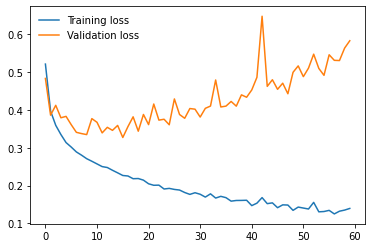

In [53]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [54]:
test_loss,test_acc = test_loop(testloader, model, criterion)

print("Result on the Final Test Set")
print("Test Loss: {:.3f}.. ".format(test_loss), "Test Accuracy: {:.3f}".format(test_acc))

Result on the Final Test Set
Test Loss: 0.560..  Test Accuracy: 0.885


## Reduce Overfitting through Early Stopping and Dropout

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. 

The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. 

1. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called **early-stopping**. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

2. Another method to reduce overfitting (outside of early-stopping) is **dropout**, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. 

**Note:** Turn off dropout during inference. Use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. 

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

### Add dropout to the model and train it again
See if you can get a lower validation loss.

In [44]:
class Classifier2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # *** Dropout module with 0.2 drop probability ***
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [45]:
def test_loop2(testloader, model, criterion):
    tot_test_loss = 0
    test_correct = 0  # Number of correct predictions on the test set
    
    # *** Turn off DROPOUT ***
    model.eval()
        
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad(): 
        for images, labels in testloader:
            
            images = images.to(my_device)
            labels = labels.to(my_device)
            
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            tot_test_loss += loss.item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_correct += equals.sum().item()
    
    # *** set model back to train mode ***
    model.train()

    test_loss = tot_test_loss / len(testloader.dataset)
    test_acc = test_correct / len(testloader.dataset)
    return test_loss, test_acc

In [46]:
model2 = Classifier2()
model2.to(my_device)

criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model2.parameters(), lr=0.003)

epochs = 90

train_losses, test_losses = [], []
    
for e in range(epochs):
    train_loss = train_loop(trainloader, model2, criterion, optimizer)
    
    test_loss,test_acc = test_loop2(validloader, model2, criterion)

    # Keep track of losses at the completion of epoch
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_loss),
          "Test Loss: {:.3f}.. ".format(test_loss),
          "Test Accuracy: {:.3f}".format(test_acc))

Epoch: 1/90..  Training Loss: 0.612..  Test Loss: 0.463..  Test Accuracy: 0.833
Epoch: 2/90..  Training Loss: 0.488..  Test Loss: 0.431..  Test Accuracy: 0.849
Epoch: 3/90..  Training Loss: 0.456..  Test Loss: 0.396..  Test Accuracy: 0.856
Epoch: 4/90..  Training Loss: 0.435..  Test Loss: 0.382..  Test Accuracy: 0.865
Epoch: 5/90..  Training Loss: 0.425..  Test Loss: 0.385..  Test Accuracy: 0.863
Epoch: 6/90..  Training Loss: 0.415..  Test Loss: 0.388..  Test Accuracy: 0.866
Epoch: 7/90..  Training Loss: 0.407..  Test Loss: 0.433..  Test Accuracy: 0.853
Epoch: 8/90..  Training Loss: 0.400..  Test Loss: 0.399..  Test Accuracy: 0.860
Epoch: 9/90..  Training Loss: 0.397..  Test Loss: 0.359..  Test Accuracy: 0.870
Epoch: 10/90..  Training Loss: 0.394..  Test Loss: 0.396..  Test Accuracy: 0.861
Epoch: 11/90..  Training Loss: 0.391..  Test Loss: 0.381..  Test Accuracy: 0.868
Epoch: 12/90..  Training Loss: 0.380..  Test Loss: 0.372..  Test Accuracy: 0.868
Epoch: 13/90..  Training Loss: 0.381.

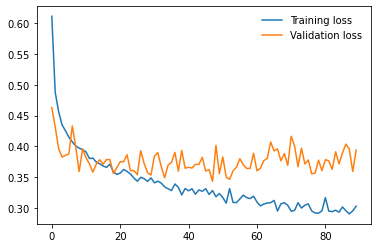

In [47]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [48]:
test_loss,test_acc = test_loop2(testloader, model2, criterion)

print("Result on the Final Test Set")
print("Test Loss: {:.3f}.. ".format(test_loss), "Test Accuracy: {:.3f}".format(test_acc))

Result on the Final Test Set
Test Loss: 0.428..  Test Accuracy: 0.875


## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

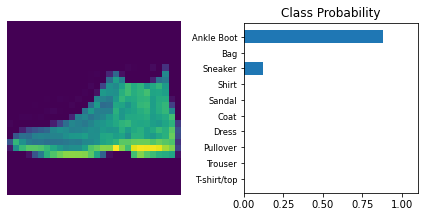

In [43]:
# Import helper module (should be in the repo)
import helper

# Test out your network!
model = model2
model.to(my_device)

dataiter = iter(testloader)
images, labels = dataiter.next()

images = images.to(my_device)
labels = labels.to(my_device)

img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    model.eval()
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28).cpu(), ps.cpu(), version='Fashion')